<a href="https://colab.research.google.com/github/AlexDuchnowski/logo-gen/blob/main/logo_gen_icon_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [1]:
!pip install tensorflow_gan
import tensorflow_gan as tfgan
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import h5py
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import csv
import glob

     |████████████████████████████████| 367 kB 7.2 MB/s 



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
for file in glob.glob("*.png"):
    os.remove(file)

## Pre-processing

In [4]:
# Global Parameters
BATCH_SIZE = 256
NUM_EPOCHS = 500
LATENT_DIM = 512
IMG_SHAPE = (32, 32, 3)
CLUSTER_CHOSEN = 62
CALLBACK_PERIOD = 50

In [5]:
def make_input_generator_with_clusters(data_file_path, cluster_file_path, batch_size, epochs):
    hdf5_file = h5py.File(data_file_path, 'r')
    clusters = read_cluster_data(cluster_file_path)
    indices = np.nonzero(clusters == CLUSTER_CHOSEN)[0]

    for n in range(epochs):
        for i in range(0, len(indices), batch_size):
            if i + batch_size >= len(indices):
                break
            indices_batch = indices[i:i+batch_size]
            # transpose from NCHW to NHWC
            images = hdf5_file['data'][indices_batch]
            images = tf.cast(tf.transpose(images, [0, 2, 3, 1]), tf.int32)
            images = process_images(images)
            yield images
        
def process_images(images):
    # transform pixel range from [0, 255] to [-1, 1] (use tanh activation in generator)
    images = (tf.cast(images, tf.float32) - 127.5) / 127.5
    return images

def read_cluster_data(cluster_file_path):
    # read in the csv file
    with open(cluster_file_path, 'r') as f:
        cluster_data = [int(float(row[0])) for row in csv.reader(f)]
    return tf.convert_to_tensor(cluster_data)

## Models

In [6]:
def get_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def get_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
g_model = get_generator_model()
g_model.summary()

d_model = get_discriminator_model()
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              4194304   
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

In [8]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 992 kB 6.3 MB/s 


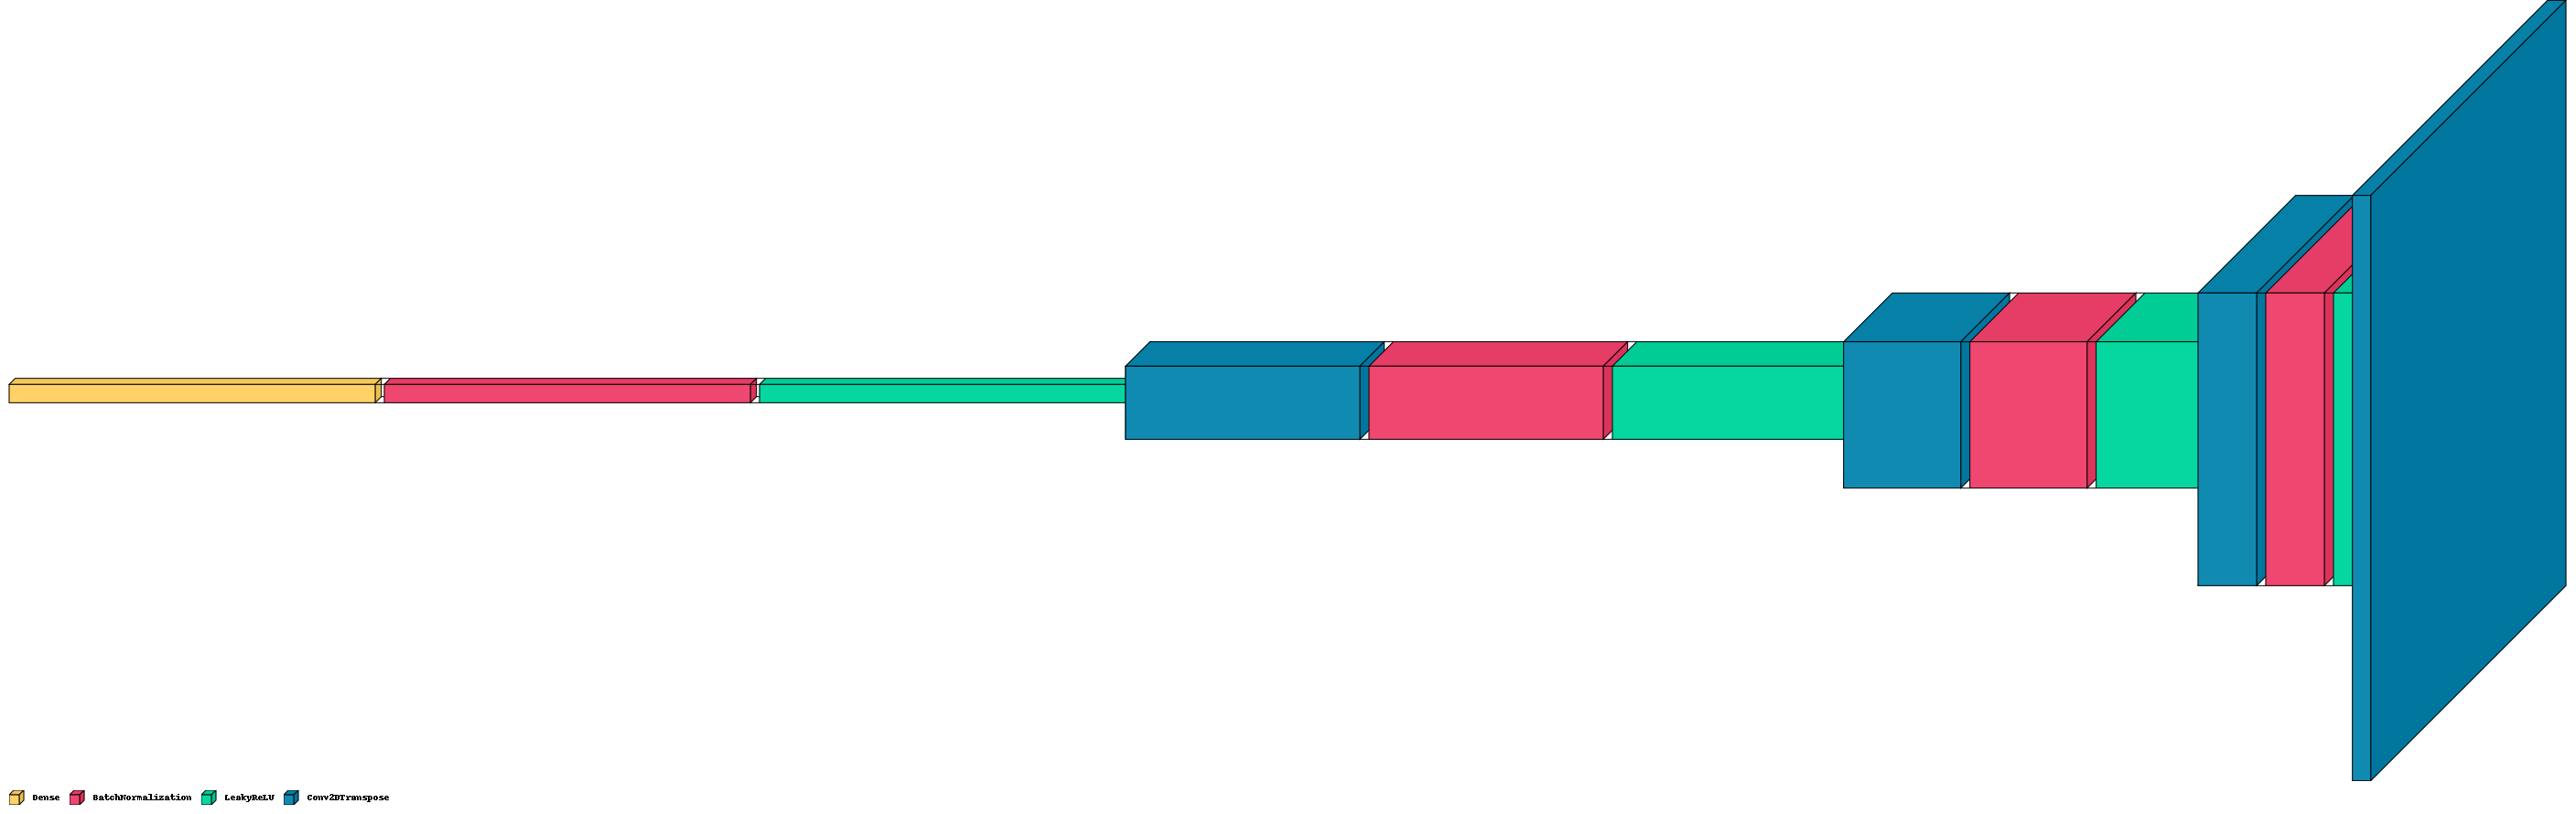

In [9]:
visualkeras.layered_view(g_model, type_ignore=[layers.Reshape], legend=True, scale_xy=20, scale_z=1, to_file='model_visualization.png')

In [10]:
class DCGAN(tf.keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
    ):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_loss = self.d_loss_fn(real_output=real_logits, fake_output=fake_logits)

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## Keras Callback

In [11]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_batch_end(self, batch, logs={}):
        if (batch % CALLBACK_PERIOD != 0):
            return
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = tf.keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{batch}_{i}.png".format(i=i, batch=batch))
        
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs.plot(range(1, batch + 2, CALLBACK_PERIOD),
                        self.metrics[metric],
                        label=metric)
                
            axs.legend()
            axs.grid()
        
        plt.title("Generator and Discriminator Loss")
        plt.xlabel("Number of Batches Trained")
        plt.ylabel("Loss")

        plt.tight_layout()
        plt.savefig('loss_graph.png')
        plt.show()

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []        

## Training the Model

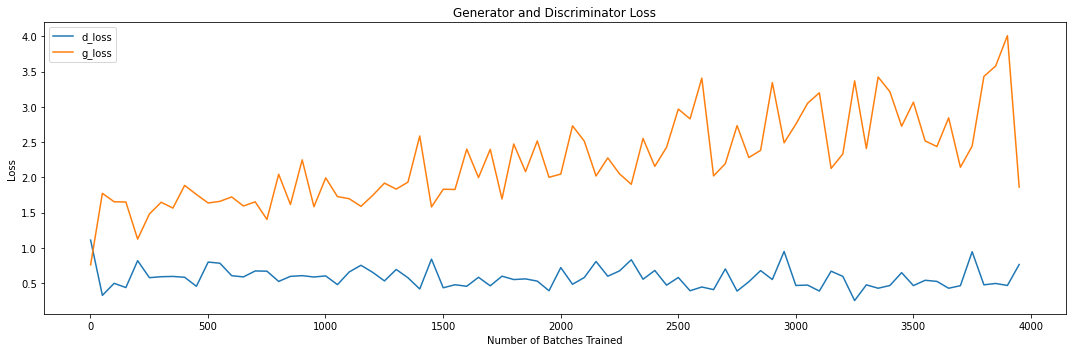

4000/4000 [==============================] - 2744s 683ms/step - d_loss: 0.5888 - g_loss: 2.2825


In [ ]:
data_file_path = '/content/drive/Shared drives/DL Final Project/Code/LLD-icon.hdf5'
cluster_file_path = '/content/drive/Shared drives/DL Final Project/Code/cluster-data/icon/64_clusters_data.csv'
gen = make_input_generator_with_clusters(data_file_path, cluster_file_path, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the loss function for the discriminator.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the loss function for the generator.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=LATENT_DIM)

# Instantiate the DCGAN model.
dcgan = DCGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=LATENT_DIM,
    discriminator_extra_steps=3,
)

# Compile the DCGAN model.
dcgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
dcgan.fit(x=gen, callbacks=[cbk])

## Evaluation Metrics

In [12]:
def inception_score(images):
    images = process_inception_input(images)
    inception_model = tf.keras.applications.InceptionV3(classifier_activation=None)
    return tfgan.eval.classifier_score(images, inception_model.predict)

def frechet_inception_distance(real_images, fake_images):
    real_images = process_inception_input(real_images)
    fake_images = process_inception_input(fake_images)
    inception_model = tf.keras.applications.InceptionV3(classifier_activation='softmax')
    return tfgan.eval.frechet_classifier_distance(real_images, fake_images, inception_model.predict)

def process_inception_input(images):
    images = tf.image.resize(images, size=[299, 299], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    images = tf.cast(images, tf.float32)
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    return images

In [ ]:
num_imgs = 1000

random_latent_vectors = tf.random.normal(shape=(num_imgs, LATENT_DIM))
generated_images = dcgan.generator(random_latent_vectors)
generated_images = tf.cast((generated_images * 127.5) + 127.5, tf.int32)

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/LLD-icon.hdf5'
gen = make_input_generator_with_clusters(data_file_path, cluster_file_path, batch_size=num_imgs, epochs=1)

print(f'Inception Score (Fake): {inception_score(generated_images)}')
print(f'Inception Score (Real): {inception_score(next(gen))}')
print(f'FID: {frechet_inception_distance(next(gen), generated_images)}')